DSS THESIS

*Packages and preparation*

In [1]:
# importing packages
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np # for mathematical operations
import pandas as pd # for dataframe processing
import re
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import spacy
import string
from scipy.sparse import csr_matrix
from mlxtend.preprocessing import DenseTransformer
from sklearn.decomposition import TruncatedSVD

pd.options.display.max_columns = None

*Dataframe initialization*

In [2]:
# loading dataframes /anti /pro

prodf = pd.read_csv('pro.csv', sep = ";", index_col = 0, low_memory = False)
antidf = pd.read_csv('anti.csv', sep = ";", index_col = 0, low_memory = False)

In [3]:
# coding sentiment
antidf['sentiment'] = np.ones(antidf.shape[0]) # coding 1 for negative sentiment
prodf['sentiment'] = np.zeros(prodf.shape[0]) # coding 0 for positive sentiment

# merging dataframes for main dataframe
df = pd.concat([antidf, prodf])

*Data cleaning*

In [ ]:
# removing columns with notna < 0.5
df.dropna(axis = 'columns', thresh = (df.shape[0]*0.5), inplace = True)

# dropping duplicates
df.drop_duplicates(subset = ['id'], keep = False, inplace = True)
df.drop_duplicates(subset = ['text'], keep = 'first', inplace = True)

# removing uninsightful and noisy variables
df.drop(columns = ['user_location', 'lang', 'retweet_id', 'retweet_screen_name', 'user_screen_name',
                   'source', 'tweet_url', 'user_id', 'user_name'], inplace = True)

# dropping nas in rows
df = df[df['user_description'].notna()]
df = df[df['hashtags'].notna()]

In [ ]:
# defining get date function
def getdate(x):
    dt = parse(x)
    return dt.date()

# defining lemmatization function
nlp = spacy.load('it_core_news_lg')

def lemmatization(inp):
    if type(inp) == None:
        return ""
    doc = nlp(inp)
    return " ".join(token.lemma_ for token in doc)

# defining cleaning text function
def clean_text(text):
    if type(text) == np.float:
        return ""
    temp = text.lower() #to lowercase all text
    temp = re.sub("'", " ", temp) # to avoid removing contractions
    temp = re.sub("@[a-z0-9_]+","", temp) # to remove mentions
    temp = re.sub("#[a-z0-9_]+","", temp) # to remove hashtags
    temp = re.sub(r'http\S+', '', temp) # to remove links
    temp = re.sub(r"www.\S+", "", temp) # to remove links
    temp = re.sub('\n', ' ', temp) # to remove enters
    temp = re.sub('[^a-z0-9àèìòù]', ' ', temp) # to remove non-alphanumeric characters
    temp = re.sub('[()!?]', ' ', temp) # to remove punctuation
    temp = re.sub('\[.*?\]',' ', temp) # to remove punctuation
    temp = temp.split() # tokenization
    temp = [w for w in temp if not w in stopwords.words("italian")] # to remove stopwords
    temp = " ".join(word for word in temp) # to rejoin tokens
    return temp

In [ ]:
# applying get date function
df['created_at'] = df['created_at'].apply(lambda x: getdate(x))
df['user_created_at'] = df['user_created_at'].apply(lambda x: getdate(x))

# datetime to integer
df['created_at'] = pd.to_datetime(df["created_at"]).dt.strftime("%Y%m%d").astype(int)
df['user_created_at'] = pd.to_datetime(df["user_created_at"]).dt.strftime("%Y%m%d").astype(int)

# applying cleaning text function to text and user description
df['clean_text'] = df['text'].apply(lambda x:clean_text(x))
df['clean_user_description'] = df['user_description'].apply(lambda x: clean_text(x))

# applying lemmatization function to text and user description
df['lemmatized_text'] = df['clean_text'].apply(lambda x: lemmatization(x))
df['lemmatized_user_description'] = df['clean_user_description'].apply(lambda x: lemmatization(x)) 

# applying cleaning text and lemmatization function to hashtags
df['clean_hashtags'] = df['hashtags'].apply(lambda x: clean_text(x))
df['lemmatized_hashtags'] = df['clean_hashtags'].apply(lambda x: lemmatization(x))

*Data preprocessing*

In [ ]:
# dropping recoded variables

df.drop(columns = ['text', 'clean_text', 'user_description', 'clean_user_description', 'hashtags', 'clean_hashtags'], inplace = True)

In [ ]:
df = df.dropna(subset=['lemmatized_text'])
df = df.dropna(subset=['lemmatized_user_description'])

In [ ]:
# resampling clean df
df = df.groupby('sentiment').sample(n = 10000, random_state = 42).reset_index(drop = True)

In [ ]:
df.to_csv('dss_thesis_datavfin.csv')

In [2]:
df = pd.read_csv('dss_thesis_datavfin.csv', sep = ",", index_col = 0, low_memory = False)
df.drop(['id', 'user_created_at'], axis=1, inplace = True)
df = df.sample(frac = 1, random_state = 42).reset_index(drop = True)

In [3]:
# prepare dataframes for text encoding
dfbow = df.copy(deep = True)
dftf = df.copy(deep = True)

In [4]:
# count vectorizer - tfidf parameters
cvectorizer = CountVectorizer(max_features = 5000, binary = True)
tfvectorizer = TfidfVectorizer(max_features = 5000)

*FULL BAG OF WORDS DATASET*

In [5]:
textbow = cvectorizer.fit_transform(dfbow['lemmatized_text']) # step 1: encode variable
textbow = textbow.todense() # step 2: matrix to dense
textbow = pd.DataFrame(textbow) # step 3: matrix to dataframe
textbow.columns = cvectorizer.get_feature_names_out() # step 4: words to column names

In [6]:
hashbow = cvectorizer.fit_transform(dfbow['lemmatized_hashtags']) # step 1: encode variable
hashbow = hashbow.todense() # step 2: matrix to dense
hashbow = pd.DataFrame(hashbow) # step 3: matrix to dataframe
hashbow.columns = [ "h_" + i for i in cvectorizer.get_feature_names_out()] # step 4: words to column names

In [7]:
dfbow.drop(columns = ['lemmatized_text', 'lemmatized_user_description', 'lemmatized_hashtags'], inplace = True)

In [8]:
dfbow = pd.concat([dfbow, textbow, hashbow], axis=1)

*FULL TF-IDF DATASET*

In [10]:
texttf = tfvectorizer.fit_transform(dftf['lemmatized_text']) # step 1: encode variable
texttf = texttf.todense() # step 2: matrix to dense
texttf = pd.DataFrame(texttf) # step 3: matrix to dataframe
texttf.columns = tfvectorizer.get_feature_names_out() # step 4: words to column names

In [11]:
hashtf = tfvectorizer.fit_transform(dftf['lemmatized_hashtags']) # step 1: encode variable
hashtf = hashtf.todense() # step 2: matrix to dense
hashtf = pd.DataFrame(hashtf) # step 3: matrix to dataframe
hashtf.columns = [ "h_" + i for i in tfvectorizer.get_feature_names_out()] # step 4: words to column names

In [12]:
dftf.drop(columns = ['lemmatized_text', 'lemmatized_user_description', 'lemmatized_hashtags'], inplace = True)

In [13]:
dftf = pd.concat([dftf, texttf, hashtf], axis=1)

*Model training and evaluation*

In [17]:
# prepare configuration for cross validation test harness
seed = 42

# prepare models
models = []
models.append(('NB', MultinomialNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

*DATAFRAME SUBSETS*

In [42]:
# subsetting the dataframe
# tweet
df_tweet = df[['created_at',
              'favorite_count',
              'retweet_count']]

df_tweet_bow = pd.concat([df_tweet, textbow], axis=1)
df_tweet_tf = pd.concat([df_tweet, texttf], axis=1)

# user
df_user = df[['user_default_profile_image',
              'user_favourites_count',
              'user_followers_count',
              'user_friends_count',
              'user_listed_count',
              'user_statuses_count',
              'user_verified']]

# entity
df_entity_bow = hashbow
df_entity_tf = hashtf

In [43]:
# tweet data split
x_bow_tweet = df_tweet_bow
y_bow_tweet = df['sentiment']

x_tf_tweet = df_tweet_tf
y_tf_tweet = df['sentiment']

# user data split
x_user = df_user
y_user = df['sentiment']

# entity data split
x_bow_ent = df_entity_bow
y_bow_ent = df['sentiment']

x_tf_ent = df_entity_tf
y_tf_ent = df['sentiment']

In [44]:
# evaluate each model in turn for tweet bow dataframe
t1_results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    t1_cv_results = model_selection.cross_val_score(model, x_bow_tweet, y_bow_tweet, cv=kfold, scoring=scoring)
    t1_results.append(t1_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, t1_cv_results.mean(), t1_cv_results.std())
    print(msg)

NB: 0.738550 (0.012527)
RF: 0.864500 (0.006384)
ETC: 0.828150 (0.010062)


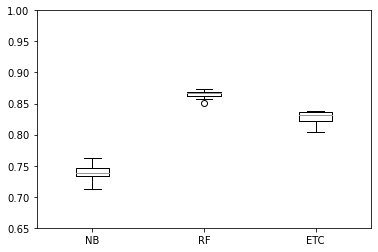

In [56]:
# boxplot algorithm comparison with tweet bow dataframe
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(t1_results)
plt.ylim(0.65, 1)
ax.set_xticklabels(names)
plt.show()

In [45]:
# evaluate each model in turn for tweet tf dataframe
t2_results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    t2_cv_results = model_selection.cross_val_score(model, x_tf_tweet, y_tf_tweet, cv=kfold, scoring=scoring)
    t2_results.append(t2_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, t2_cv_results.mean(), t2_cv_results.std())
    print(msg)

NB: 0.706150 (0.011651)
RF: 0.863300 (0.006867)
ETC: 0.856250 (0.008238)


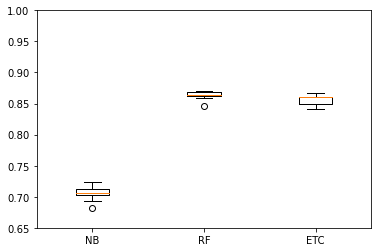

In [55]:
# boxplot algorithm comparison with tweet tf dataframe
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(t2_results)
plt.ylim(0.65, 1)
ax.set_xticklabels(names)
plt.show()

In [46]:
# evaluate each model in turn for user dataframe
u1_results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    u1_cv_results = model_selection.cross_val_score(model, x_user, y_user, cv=kfold, scoring=scoring)
    u1_results.append(u1_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, u1_cv_results.mean(), u1_cv_results.std())
    print(msg)

NB: 0.534300 (0.013589)
RF: 0.864250 (0.005483)
ETC: 0.863600 (0.006107)


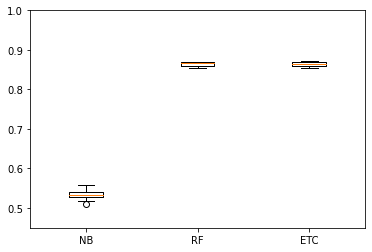

In [59]:
# boxplot algorithm comparison with user dataframe
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(u1_results)
plt.ylim(0.45, 1)
ax.set_xticklabels(names)
plt.show()

NB: 0.986750 (0.002839)
RF: 0.984900 (0.003590)
ETC: 0.985300 (0.003132)


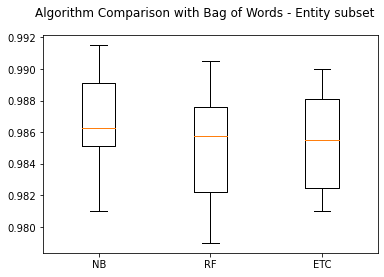

In [47]:
# evaluate each model in turn for hashtag bow dataframe
h1_results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    h1_cv_results = model_selection.cross_val_score(model, x_bow_ent, y_bow_ent, cv=kfold, scoring=scoring)
    h1_results.append(h1_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, h1_cv_results.mean(), h1_cv_results.std())
    print(msg)

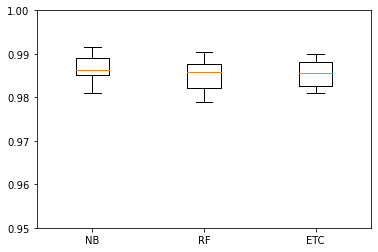

In [53]:
# boxplot algorithm comparison for hashtags bow dataframe
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(h1_results)
plt.ylim(0.95, 1)
ax.set_xticklabels(names)
plt.show()

NB: 0.982850 (0.003369)
RF: 0.985000 (0.003332)
ETC: 0.985650 (0.003025)


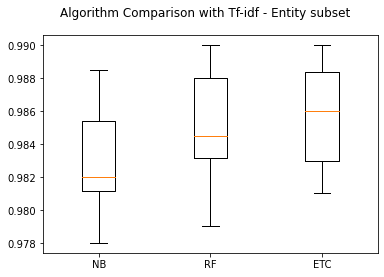

In [48]:
# evaluate each model in turn for hashtag tf dataframe
h2_results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    h2_cv_results = model_selection.cross_val_score(model, x_tf_ent, y_tf_ent, cv=kfold, scoring=scoring)
    h2_results.append(h2_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, h2_cv_results.mean(), h2_cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison with Tf-idf - Entity subset')
ax = fig.add_subplot(111)
plt.boxplot(h2_results)
ax.set_xticklabels(names)
plt.show()

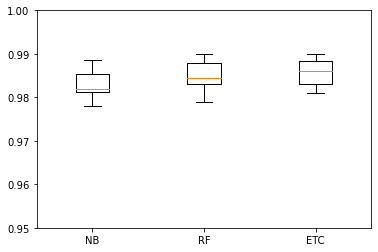

In [52]:
# boxplot algorithm comparison with hashtags tf-idf dataframe
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(h2_results)
plt.ylim(0.95, 1)
ax.set_xticklabels(names)
plt.show()

FINAL FULL DATASET MODEL EVALUATION

In [ ]:
dfbow = pd.concat([dfbow, textbow], axis=1)
dftf = pd.concat([dftf, texttf], axis=1)

In [15]:
# preparing data for split - BoW
data_Xbow = dfbow[[col for col in dfbow.columns if col != 'sentiment']]
data_Ybow = dfbow['sentiment'] 

In [16]:
# preparing data for split - Tf-idf
data_Xtf = dftf[[col for col in dftf.columns if col != 'sentiment']]
data_Ytf = dftf['sentiment'] 

In [18]:
# evaluate each model in turn for full final bow dataframe
f1_results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    f1_cv_results = model_selection.cross_val_score(model, data_Xbow, data_Ybow, cv=kfold, scoring=scoring)
    f1_results.append(f1_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, f1_cv_results.mean(), f1_cv_results.std())
    print(msg)

NB: 0.543600 (0.007677)
RF: 0.894600 (0.003499)
ETC: 0.842750 (0.007414)


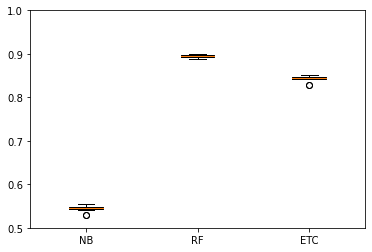

In [23]:
# boxplot algorithm comparison with full final bow dataset
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(f1_results)
plt.ylim(0.5, 1)
ax.set_xticklabels(names)
plt.show()

In [20]:
# evaluate each model in turn for full tf-idf dataframe
f2_results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    f2_cv_results = model_selection.cross_val_score(model, data_Xtf, data_Ytf, cv=kfold, scoring=scoring)
    f2_results.append(f2_cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, f2_cv_results.mean(), f2_cv_results.std())
    print(msg)

NB: 0.543600 (0.007677)
RF: 0.893700 (0.005984)
ETC: 0.869900 (0.006480)


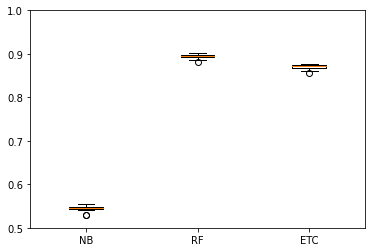

In [22]:
# boxplot algorithm comparison with full tf-idf dataframe
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(f2_results)
plt.ylim(0.5, 1)
ax.set_xticklabels(names)
plt.show()